# Explore functional network associations

In [1]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

/home/jovyan/work/notebooks


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [22]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
hcp_scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/hcp_3d_ds5_spin_5000.npy")

## FC strength & age effect

In [62]:
pd.concat([
    pd.read_csv("../data/str_cort_14.txt", header=None, names=['FC_strength_age14']),
    pd.read_csv("../data/str_cort_age_t.txt", header=None, names=['FC_strength_age_t'])
], axis=1).reindex(range(1,361)).assign(label=get_labels_hcp()).to_csv("../data/vasa_FC_model.csv")

In [94]:
fc_age = (pd.read_csv("../data/vasa_FC_model.csv", index_col=0).iloc[:180,:].set_index('label')
            .apply(lambda x: (x-np.mean(x))/np.std(x)))
fc_age.shape

(180, 2)

In [95]:
fc_age_scatter = (fc_age
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(hcp_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='G', value_name='G_score')
)
fc_age_scatter

,map,map_score,G,G_score
label,,,,
1,FC_strength_age14,0.899321,G1,1.458617
1,FC_strength_age_t,1.563648,G1,1.458617
10d,FC_strength_age14,-0.049395,G1,NaN
10d,FC_strength_age_t,-0.876121,G1,NaN
10pp,FC_strength_age14,-0.732155,G1,NaN
...,...,...,...,...
s32,FC_strength_age_t,NaN,G3,0.079859
s6-8,FC_strength_age14,0.181961,G3,NaN
s6-8,FC_strength_age_t,0.763890,G3,NaN


In [96]:
fc_age_null_p = (corr_nulls_from_grads(null_scores, hcp_scores, fc_age, method='pearsonr')
                .join(fc_age_scatter.groupby(['map','G']).min(), on=('map','G'))
                .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

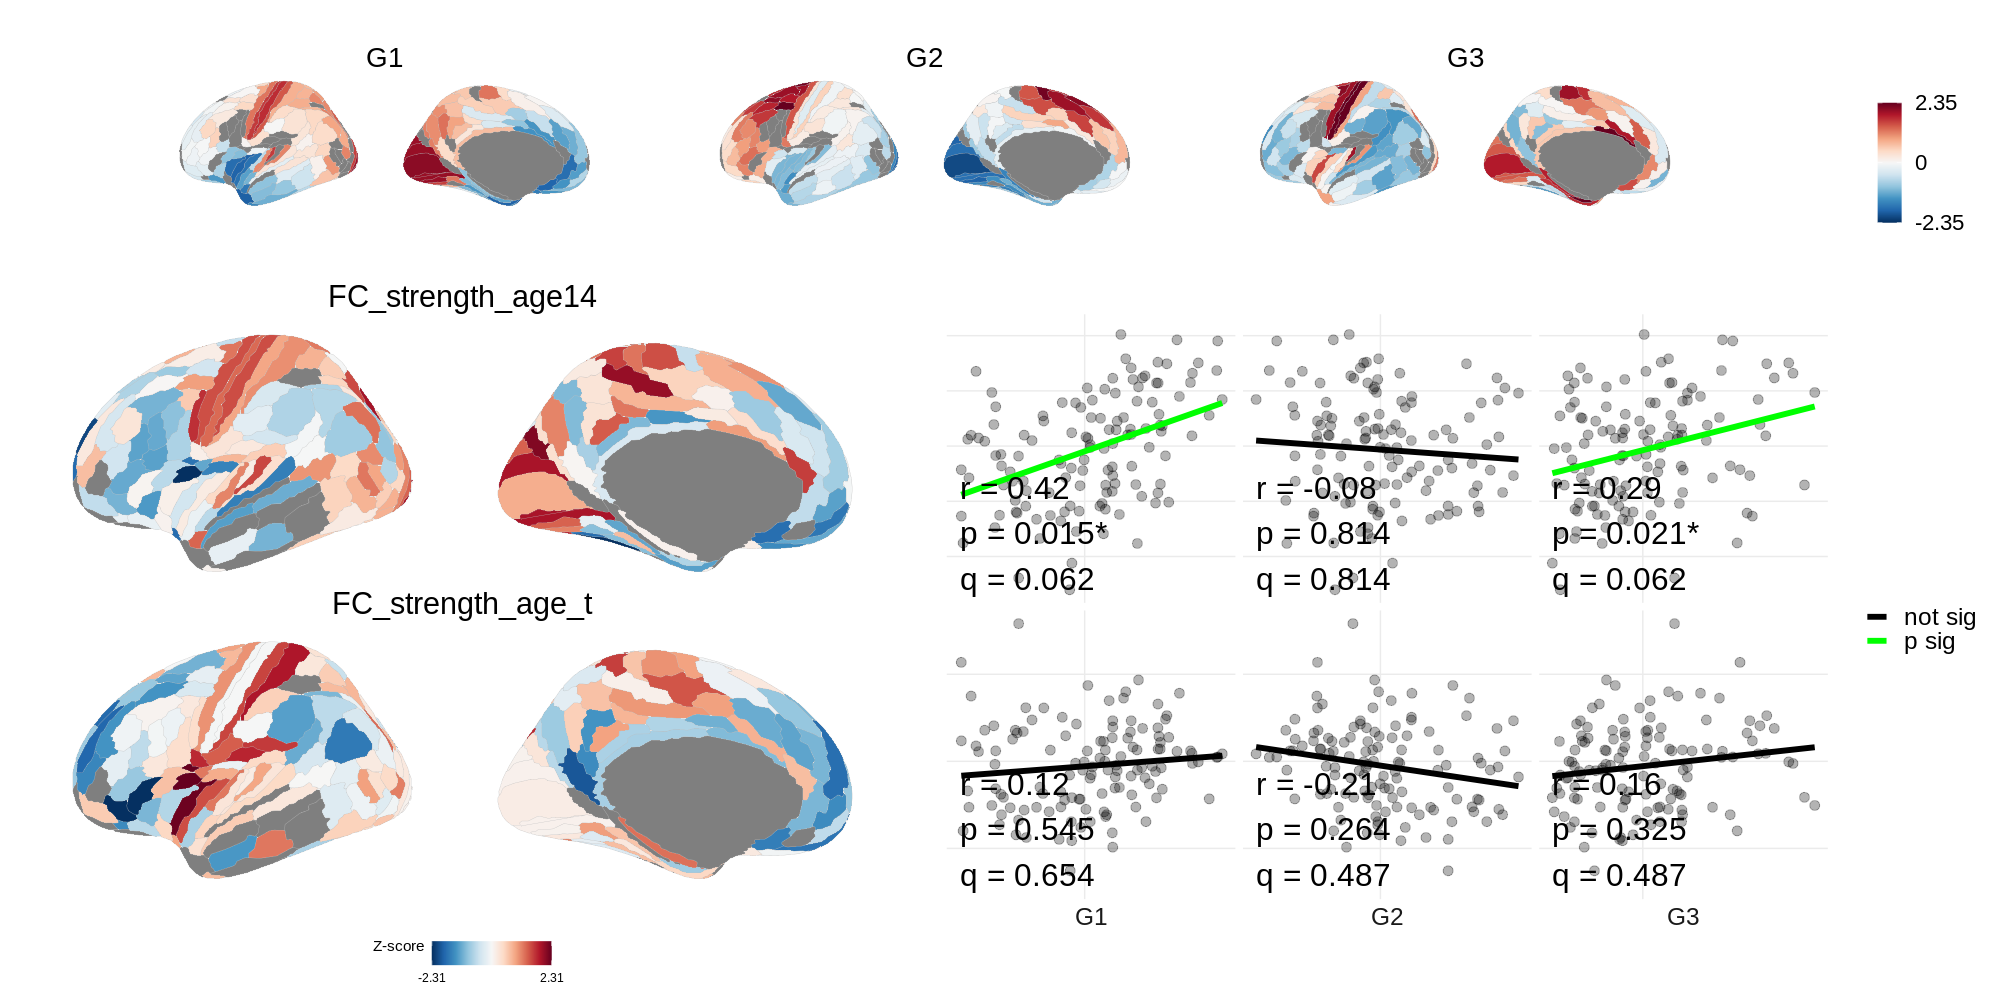

In [97]:
%%R -i hcp_scores -i fc_age -i fc_age_scatter -i fc_age_null_p -w 20 -h 10 --units in -r 100
source("../code/plot_maps.R")
g0 <- plot_hcp_wide(hcp_scores)
g1 <- plot_maps(fc_age, ncol=1) & theme(strip.text=element_text(size=22))
g2 <- plot_maps_scatter(fc_age_scatter, fc_age_null_p) & theme(text=element_text(size=22), strip.text.y.left=element_blank())
(g0 / (g1 + g2)) + plot_layout(heights=c(1,4))

## Dynamic FC (with edges!)

In [ ]:
dyn_fc = pd.read_csv("../data/dynamic_fc/FC.DYN.EDGE.14.csv", index_col=0)

: 

: 

In [ ]:
np.array(dyn_fc)

In [38]:
dynamic_fc = (pd.read_csv("../data/dynamic.fc.v2.csv")
        .reindex(range(1,361)).assign(label = get_labels_hcp())
        .iloc[:180].set_index('label')
        # .apply(lambda x: np.clip(x, upper=np.quantile(x,.9), lower=np.quantile(x,.1)))
        .apply(lambda x: (x-np.mean(x))/np.std(x))
        # .drop(['dyn.fc.age.2', 'sd.dyn.fc.age.2'],axis=1)
)
dynamic_fc

,dyn.fc.14,dyn.fc.25,dyn.fc.age,sd.dyn.fc.14,sd.dyn.fc.25,sd.dyn.fc.age
label,,,,,,
V1,0.814638,0.787832,0.214877,0.912039,0.730340,-0.139387
MST,1.244515,1.314837,0.829737,1.107494,0.903898,0.164060
V6,1.916466,1.545182,-0.152283,1.789689,1.052518,-0.929816
V2,1.608096,1.251870,-0.213069,1.366042,0.782058,-0.722471
V3,1.022519,0.720038,-0.211744,0.581521,0.102866,-0.767879
...,...,...,...,...,...,...
STSva,NaN,NaN,NaN,NaN,NaN,NaN
TE1m,-1.017511,-0.105875,1.789487,-0.860625,0.322455,2.473904
PI,-0.073230,-0.420326,-0.758302,-0.101584,-0.624300,-1.360538


In [39]:
dynamic_fc_scatter = (dynamic_fc
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(hcp_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='G', value_name='G_score')
)

In [40]:
dynamic_fc_null_p = (corr_nulls_from_grads(null_scores, hcp_scores, dynamic_fc, method='pearsonr')
                .join(dynamic_fc_scatter.groupby(['map','G']).min(), on=('map','G'))
                .rename({'map_score':'y', 'G_score':'x'},axis=1)
)

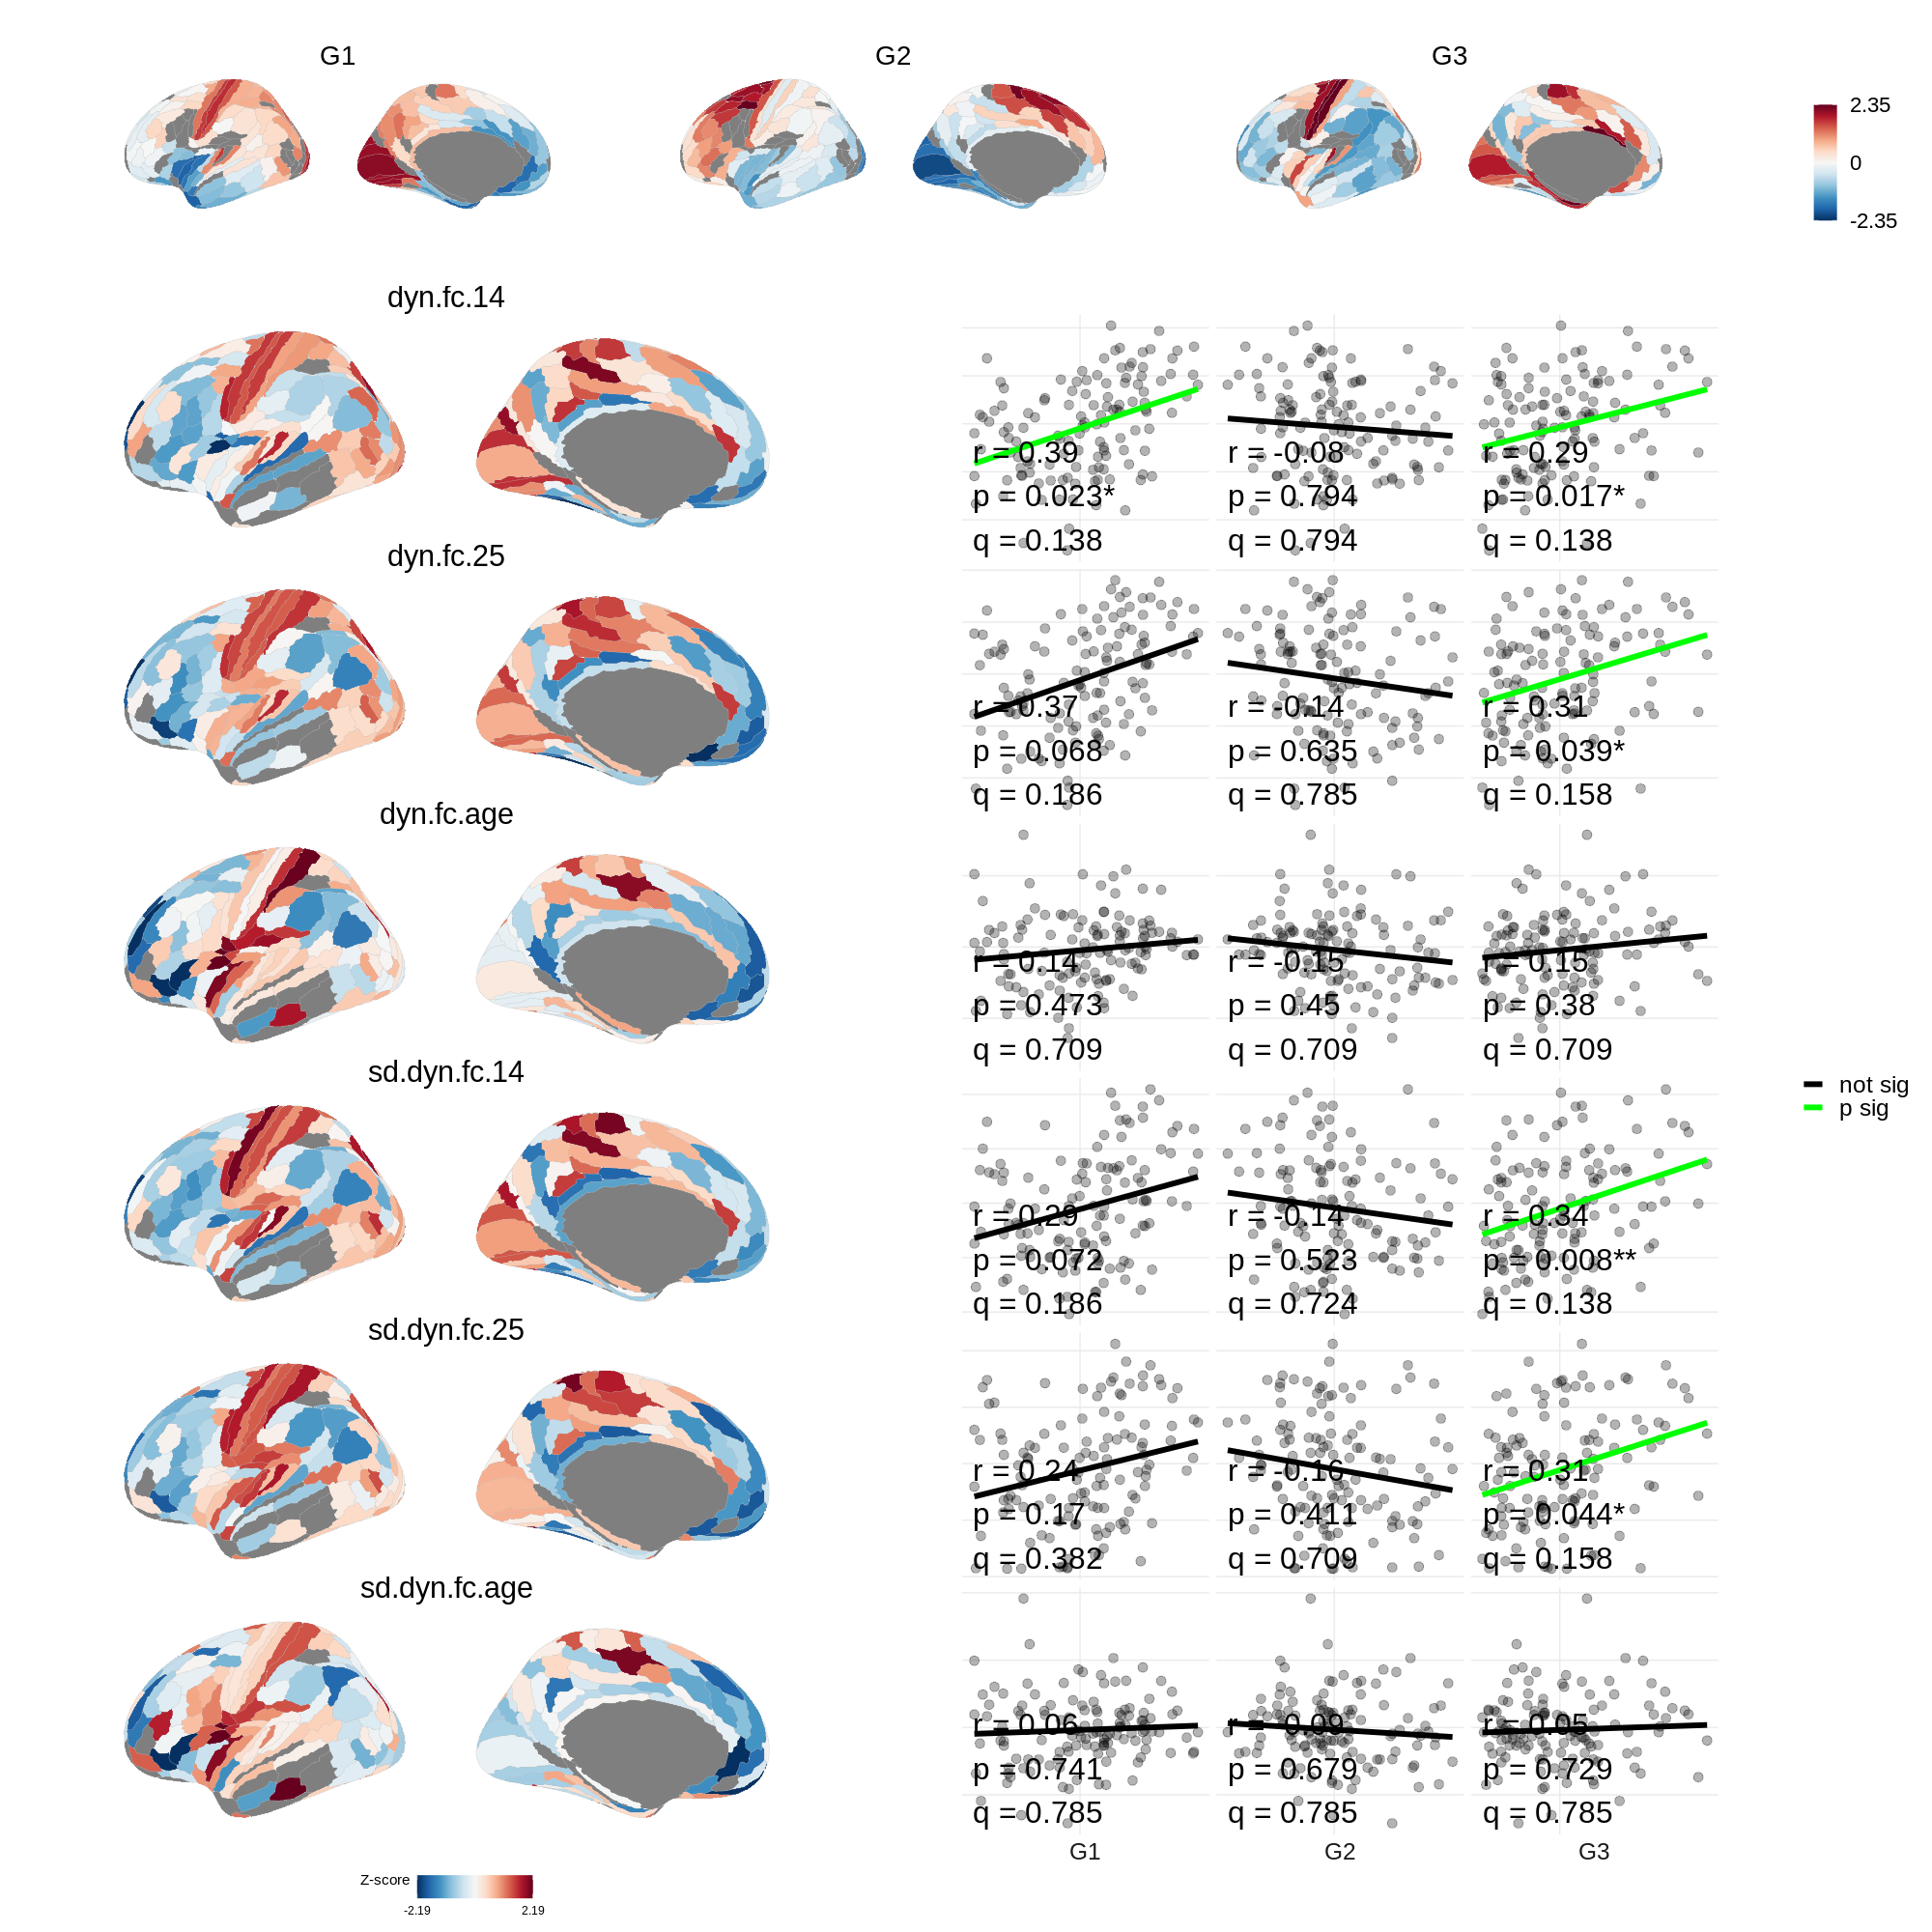

In [41]:
%%R -i hcp_scores -i dynamic_fc -i dynamic_fc_scatter -i dynamic_fc_null_p -w 20 -h 20 --units in -r 100
source("../code/plot_maps.R")
g0 <- plot_hcp_wide(hcp_scores)
g1 <- plot_maps(dynamic_fc, ncol=1) & theme(strip.text=element_text(size=22))
g2 <- plot_maps_scatter(dynamic_fc_scatter, dynamic_fc_null_p) & theme(text=element_text(size=22), strip.text.y.left=element_blank())
(g0 / (g1 + g2)) + plot_layout(heights=c(1,10))

## Yeo PLS

In [226]:
region_labels = dme_3d_ds5.clean_scores()['label']
weights = dme_3d_ds5.weights

In [210]:
yeo = (pd.read_csv("../data/mesulam_ve_yeo.csv", index_col=0)
        .set_index('label').loc[:,['Yeo']]
)
yeo_dummies = pd.get_dummies(yeo, columns=['Yeo']).loc[region_labels]

In [299]:
X = dme_3d_ds5.expression
y = yeo_dummies
pls_yeo = PLSCanonical(n_components=8).fit(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 6
  warnings.warn(f"Y residual is constant at iteration {k}")


In [227]:
yeo_genes = pd.DataFrame(pls_yeo.x_weights_, index=weights.index)

In [ ]:
pls_yeo.x_weights_

array([[ 0.01225432, -0.00572217, -0.00590077, ..., -0.00692168,
         0.        ,  0.        ],
       [ 0.009699  ,  0.00473935, -0.00689904, ..., -0.02091956,
         0.        ,  0.        ],
       [-0.0094024 ,  0.0093053 ,  0.00135608, ..., -0.02533507,
         0.        ,  0.        ],
       ...,
       [-0.01595229,  0.01237399,  0.0006654 , ...,  0.00029484,
         0.        ,  0.        ],
       [-0.01615461, -0.01014485, -0.01038105, ..., -0.00888595,
         0.        ,  0.        ],
       [ 0.01030767, -0.00455407,  0.0007169 , ...,  0.00267597,
         0.        ,  0.        ]])

In [319]:
# correlate(pls_yeo.transform(X, y)[0], pls_yeo.transform(X, y)[1])
pearsonr(pls_yeo.transform(X, y)[0][:,0], pls_yeo.transform(X, y)[1][:,0])
pearsonr(pls_yeo.transform(X, y)[0][:,1], pls_yeo.transform(X, y)[1][:,1])
pearsonr(pls_yeo.transform(X, y)[0][:,2], pls_yeo.transform(X, y)[1][:,2])
# pls_yeo.transform(X, y)[1]

PearsonRResult(statistic=0.6688603738735425, pvalue=4.1773796090147514e-19)

In [228]:
correlate(weights, yeo_genes)

,0,1,2,3,4,5,6,7
0,-0.979862,0.152240,0.058725,-0.010786,-0.007227,0.026305,NaN,NaN
1,0.179787,0.898754,-0.088306,-0.042500,-0.048167,0.132860,NaN,NaN
2,-0.048716,-0.051900,-0.716102,0.219199,0.106177,0.078218,NaN,NaN
3,-0.152761,0.165403,0.041998,-0.227075,0.465169,-0.295373,NaN,NaN
4,0.024436,0.059774,-0.251386,0.678173,0.077259,-0.194787,NaN,NaN


## Connectivity

In [37]:
import nibabel as nib
fc = nib.load("../data/average_fc.pconn.nii").get_fdata()
sc = nib.load("../data/average_sc.pconn.nii").get_fdata()

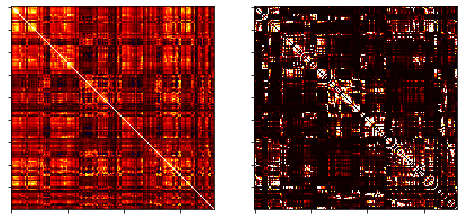

In [193]:
from nilearn.plotting import plot_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2,figsize=(8, 4))
plot_matrix(fc[:180,:180], axes=axes[0], cmap='cold_hot', vmax=.8, vmin=-.8, colorbar=False)
plot_matrix(sc[:180,:180], axes=axes[1], cmap='cold_hot', vmax=1.2, vmin=-1.2, colorbar=False)


In [2]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [148]:
version = dme_3d_ds5
regions = version.scores.index
scores = version.scores.apply(lambda x: (x-np.min(x)))
triu_indices = np.triu_indices(len(regions), k=1)

score_matrices = [np.outer(scores[i],scores[i]) for i in range(3)]
score_arrays = [score_matrices[i][triu_indices] for i in range(3)]

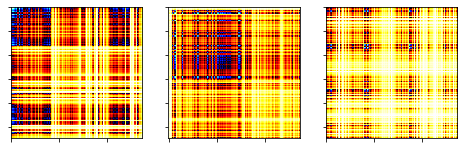

In [149]:
fig, axes = plt.subplots(1,3,figsize=(8, 4))
for i in range(3):
    plot_matrix(score_matrices[i], axes=axes[i], cmap='cold_hot_r', colorbar=False)

In [316]:
from scipy.stats import pearsonr
fc_array = fc[regions, :][:, regions][triu_indices]
sc_array = sc[regions, :][:, regions][triu_indices]

print("Functional:")
for i in range(3):
    print(round(pearsonr(score_arrays[i], fc_array)[0],4))

print("Structural:")
for i in range(3):
    print(round(pearsonr(score_arrays[i], sc_array)[0],4))

Functional:
0.3169
-0.0305
0.0476
Structural:
0.008
0.0013
0.0065


In [166]:
from sklearn.cross_decomposition import PLSCanonical
X = np.stack(score_arrays).T
y = fc_array
pls = PLSCanonical(n_components=1).fit(X,y)

In [171]:
pls.x_weights_

array([[ 0.98444184],
       [-0.09475678],
       [ 0.14797098]])

In [190]:
np.corrcoef(np.stack(pls.transform(X, y)).squeeze())

array([[1.       , 0.3221599],
       [0.3221599, 1.       ]])

## FC strength PLS

In [261]:
fc_strength = fc.mean(0)[regions]
for i in range(3):
    print(pearsonr(dme_3d_ds5.scores[i], fc_strength))

PearsonRResult(statistic=0.5566843710576358, pvalue=1.6226741221899689e-12)
PearsonRResult(statistic=-0.12492824715419046, pvalue=0.1457926459370681)
PearsonRResult(statistic=0.10865537894951519, pvalue=0.2062762349329277)


In [262]:
X = dme_3d_ds5.expression
y = fc_strength
pls_fc_strength = PLSCanonical(n_components=1).fit(X,y)

In [250]:
genes_fc_strength = pls_fc_strength.x_weights_.squeeze()
for i in range(3):
    print(pearsonr(dme_3d_ds5.weights[i], genes_fc_strength))

-0.9745964034269426
0.14378145212178314
-0.07926149148999855


In [260]:
x_scores, y_scores = pls_fc_strength.transform(X, y)
pearsonr(x_scores.squeeze(), y_scores.squeeze())

PearsonRResult(statistic=0.5692649825538781, pvalue=3.9170546838506125e-13)

## FC edges PLS

In [288]:
exp = dme_3d_ds5.expression.values
tri = np.triu_indices(exp.shape[0])
exp_cross = np.zeros([len(tri[0]), exp.shape[1]])
for gene in range(exp.shape[1]):
    exp_cross[:,gene] = np.outer(exp[:,gene], exp[:,gene])[tri]

In [293]:
fc_array = fc[regions, :][:, regions][tri]

In [295]:
pls_fc_edges = PLSCanonical(n_components=1).fit(exp_cross, fc_array)

In [298]:
genes_fc_edges = pls_fc_edges.x_weights_.squeeze()
for i in range(3):
    print(pearsonr(dme_3d_ds5.weights[i], genes_fc_edges))

PearsonRResult(statistic=0.9791492170378517, pvalue=0.0)
PearsonRResult(statistic=-0.11400929480807193, pvalue=1.7558920389889833e-24)
PearsonRResult(statistic=0.04995390840314093, pvalue=8.098854447133269e-06)
